# Build Autoencoder in Keras

In this tutorial, we will answer some common questions about autoencoders, and we will cover code examples of the following models:

    - a simple autoencoder based on a fully-connected layer
    - a sparse autoencoder (not currently working)
    - a deep fully-connected autoencoder
    - a deep convolutional autoencoder (also available in part 1)
    
    
**Note: all code examples have been updated to the Keras 2.0 API on March 14, 2017. You will need Keras version 2.0.0 or higher to run them.**

In [1]:
import keras
print(keras.__version__)

2.0.8


Using TensorFlow backend.


## Python Environment

This tutorial assumes you have a Python SciPy environment installed. You can use either Python 2 or 3 with this tutorial.

You must have Keras (2.0 or higher) installed with either the TensorFlow or Theano backend.

The tutorial also assumes you have scikit-learn, Pandas, NumPy, and Matplotlib installed.

If you need help with your environment, [this](https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/) link is here to rescue.

## What are autoencoders?

<img src= 'https://blog.keras.io/img/ae/autoencoder_schema.jpg'/>

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

    1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.
    
    2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.
    
    3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: 
    - an encoding function, 
    - a decoding function, and 
    - a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). 

The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

Note that even Autoencoding is a data compression algorithm, autoencoders are *not* good at data compression, so ...

## What are autoencoders good for?

Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on [Github](https://github.com/kylemcdonald/Parametric-t-SNE/blob/master/Parametric%20t-SNE%20(Keras).ipynb). Otherwise [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) also has a simple and practical implementation.

Autoencoders have long been thought to be a potential avenue for solving the problem of **unsupervised learning**, i.e. the learning of useful representations without the need for labels. Then again, autoencoders are not a **true** unsupervised learning technique (which would imply a different learning process altogether), they are a *self-supervised* technique, *a specific instance of supervised learning where the targets are generated from the input data*. In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here.

## Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

In [3]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's create a separate encoder and a decoder for illustration purpose.

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel **binary crossentropy loss**, and the **Adadelta** optimizer:

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#### For your information 
Cross-entropy loss, or *log loss*, measures the performance of a classification model whose output is a probability value between 0 and 1. The predictive results from most binary classification model are **not** 0/1, but a probability between [0,1].

Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A **perfect** model would have a log loss of 0.

In other words, a classifier is good when log loss is low (close to 0). In this case, log loss refer to in each pixel of the image, is it the same (1) or different (0) comparing between the original and decoded images?

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784. The value between 0 and 1 refers to the grayscale value of the pixel in the image.

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### YOUR TURN HERE

Q: Use the **context of our classifcaition problem**, please explain what the two tuple above means.

A: (double click and fill your answer here)

Now let's train our autoencoder for 50 epochs:

#### For your information

In machine-learning parlance, an epoch is a **complete** pass through a given dataset. That is, by the end of one epoch, your neural network – be it a restricted Boltzmann machine, convolutional net or deep-belief network – will have been exposed to *every record to example within the dataset once*. Not to be confused with an iteration, which is simply **one** update of the neural net model’s parameters. **Many iterations can occur before an epoch is over**. Epoch and iteration are only synonymous if you update your parameters once for each pass through the whole dataset; if you update using mini-batches, they mean different things. 

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.3701 - val_loss: 0.2733
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.2670 - val_loss: 0.2574
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.2478 - val_loss: 0.2354
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.2273 - val_loss: 0.2168
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.2113 - val_loss: 0.2030
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.1993 - val_loss: 0.1926
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.1902 - val_loss: 0.1846
Epoch 8/50
60000/60000 [==============================] - 1s - loss: 0.1831 - val_loss: 0.1784
Epoch 9/50
60000/60000 [==============================] - 1s - loss: 0.1772 - val_loss: 0.1731
Epoch 10/50
60000/60000 [==============================] - 1s - loss: 0.1722 - val_loss: 0.1683

### YOUR TURN HERE
Q: Please observe the training history, and answer whether the autoencoder is improved after training? And why?

A: (double click and fill your answer here)

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

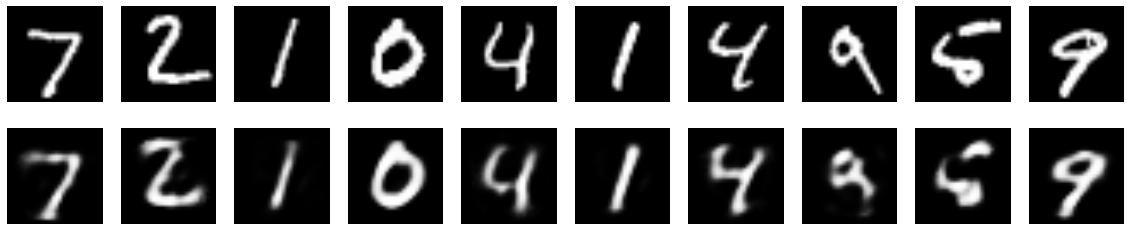

In [10]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. 

### YOUR TURN HERE
Q: please discuss how the reconstructed images comparing to the original images.

A: (double click and fill your answer here)

### Hands-on: how to improve the model?
The quality of the autoencoder we trained, or of any basic autoencoder, is depending on two parameters:
    - Encoding dimension (in code block [2])
    - Number of Epochs (in code block [7])
Try changing these two parameters, and rerun the code (do not forget to **restart the kernel**), to see how to optimize the model.

## Deep autoencoder

To further improve the performance of our autoencoder, we do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

**NOTE that you have to pair an encoder with a decoder.**

In [11]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [12]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s - loss: 0.3495 - val_loss: 0.2625
Epoch 2/100
60000/60000 [==============================] - 2s - loss: 0.2560 - val_loss: 0.2474
Epoch 3/100
60000/60000 [==============================] - 2s - loss: 0.2393 - val_loss: 0.2288
Epoch 4/100
60000/60000 [==============================] - 3s - loss: 0.2232 - val_loss: 0.2154
Epoch 5/100
60000/60000 [==============================] - 3s - loss: 0.2090 - val_loss: 0.2013
Epoch 6/100
60000/60000 [==============================] - 3s - loss: 0.1945 - val_loss: 0.1874
Epoch 7/100
60000/60000 [==============================] - 3s - loss: 0.1849 - val_loss: 0.1798
Epoch 8/100
60000/60000 [==============================] - 3s - loss: 0.1772 - val_loss: 0.1711
Epoch 9/100
60000/60000 [==============================] - 3s - loss: 0.1698 - val_loss: 0.1646
Epoch 10/100
60000/60000 [==============================] - 3s - loss: 0.1641 - val_lo

You can observe from the training history, in order to learn the weights in all the neurons of the encoding/decoding layes, we need more epochs (100 vs. 50) to get a slightly better loss. The models ends with a train loss of 0.1017 and test loss of 0.1011. 

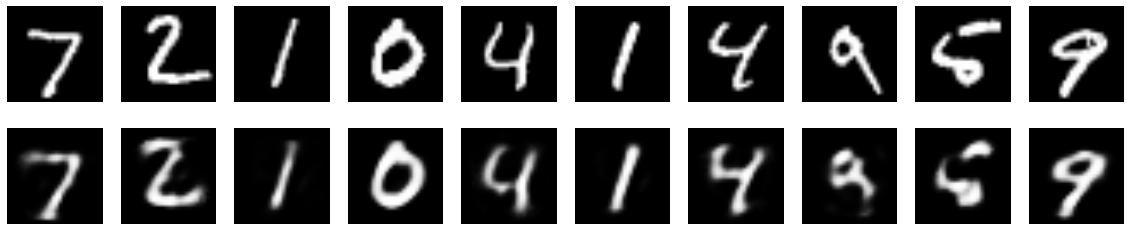

In [13]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### YOUR TURN HERE
Q: Comparing this to the results in the previous example, is it better?

A: (double click and fill your answer here)

## Convolutional autoencoder

Since our inputs are images, it makes sense to use [convolutional neural networks (convnets)](https://www.safaribooksonline.com/library/view/deep-learning/9781491924570/ch04.html) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [16]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))
                #,callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 59s - loss: 0.0309 - val_loss: 0.0054
Epoch 2/50
60000/60000 [==============================] - 60s - loss: 0.0043 - val_loss: 0.0041
Epoch 3/50
60000/60000 [==============================] - 62s - loss: 0.0040 - val_loss: 0.0040
Epoch 4/50
60000/60000 [==============================] - 62s - loss: 0.0040 - val_loss: 0.0040
Epoch 5/50
60000/60000 [==============================] - 63s - loss: 0.0040 - val_loss: 0.0040
Epoch 6/50
60000/60000 [==============================] - 62s - loss: 0.0040 - val_loss: 0.0040
Epoch 7/50
60000/60000 [==============================] - 61s - loss: 0.0040 - val_loss: 0.0040
Epoch 8/50
60000/60000 [==============================] - 68s - loss: 0.0040 - val_loss: 0.0040
Epoch 9/50
60000/60000 [==============================] - 62s - loss: 0.0040 - val_loss: 0.0040
Epoch 10/50
60000/60000 [==============================] - 62s - loss: 0.0040 - val_lo

In [24]:
# utility function for showing images
def show_imgs(x_test, decoded_imgs=None, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

input (upper row)
decoded (bottom row)


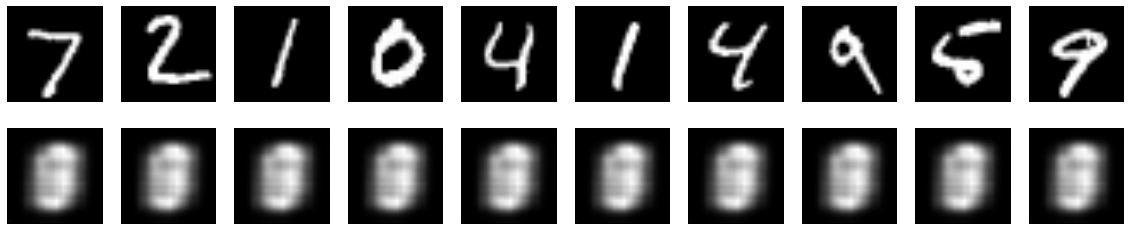

In [25]:
decoded_imgs = autoencoder.predict(x_test)

print("input (upper row)\ndecoded (bottom row)")
show_imgs(x_test, decoded_imgs)